In [2]:
!pip install gymnasium[atari]
!pip install ale-py
!pip install autorom

In [3]:
!sudo update-alternatives --config python3
!python3 -m pip install --upgrade pip
!python3 -m pip install "gymnasium[atari]" ale-py autorom
!which python3
!python3 --version
!wget https://bootstrap.pypa.io/get-pip.py
!python3 get-pip.py
!python3 -m pip --version
!python3 -m pip install "gymnasium[atari]==0.29.1"
!python3 -m pip install "ale-py==0.8.1"
!python3 -m pip install autorom
!python3 -m AutoROM --accept-license
!python3 -m pip install "gymnasium[atari]" ale-py AutoROM AutoROM.accept-rom-license

!python3 -m AutoROM.accept_rom_license --accept-license
import gymnasium as gym
import ale_py

gym.register_envs(ale_py)
print("Atari envs registered!")

gym.pprint_registry()

There are 2 choices for the alternative python3 (providing /usr/bin/python3).

  Selection    Path                 Priority   Status
------------------------------------------------------------
* 0            /usr/bin/python3.12   2         auto mode
  1            /usr/bin/python3.10   1         manual mode
  2            /usr/bin/python3.12   2         manual mode

Press <enter> to keep the current choice[*], or type selection number: 1
update-alternatives: using /usr/bin/python3.10 to provide /usr/bin/python3 (python3) in manual mode
/usr/bin/python3: No module named pip
/usr/bin/python3: No module named pip
/usr/bin/python3
Python 3.10.12
--2025-12-02 23:55:11--  https://bootstrap.pypa.io/get-pip.py
Resolving bootstrap.pypa.io (bootstrap.pypa.io)... 151.101.0.175, 151.101.64.175, 151.101.128.175, ...
Connecting to bootstrap.pypa.io (bootstrap.pypa.io)|151.101.0.175|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2182415 (2.1M) [text/x-python]
Saving to: ‘g

In [4]:
!pip install "gymnasium[atari]==0.29.1"
!pip install "ale-py==0.8.1"
!pip install autorom

In [ ]:
import os
import random
import numpy as np
from collections import deque

import gymnasium as gym
from gymnasium.wrappers import AtariPreprocessing, FrameStackObservation

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

#  Utils
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

#  PPO CNN Policy for Pong

class PPOAtariPolicy(nn.Module):
    def __init__(self, action_dim: int):
        super().__init__()

        
        self.conv = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )

    
        self.fc = nn.Sequential(
            nn.Linear(3136, 512),
            nn.ReLU(),
        )

        self.pi = nn.Linear(512, action_dim)   
        self.v = nn.Linear(512, 1)             

    def forward(self, x: torch.Tensor):
        
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        logits = self.pi(x)
        value  = self.v(x).squeeze(-1)
        return logits, value

    def get_action_and_value(self, x: torch.Tensor, action: torch.Tensor = None):
        logits, value = self.forward(x)
        dist = Categorical(logits=logits)
        if action is None:
            action = dist.sample()
        log_prob = dist.log_prob(action)
        entropy = dist.entropy()
        return action, log_prob, entropy, value

#  Environment helpers

def make_single_pong_env(seed: int = 0):
    

    def thunk():
        env = gym.make(
            "ALE/Pong-v5",
            frameskip=1,
            repeat_action_probability=0.0,
            render_mode=None,
        )

        env = AtariPreprocessing(
            env,
            frame_skip=4,
            screen_size=84,
            grayscale_obs=True,
            scale_obs=False,
        )

        env = FrameStackObservation(env, stack_size=4)


        env.reset(seed=seed)
        return env

    return thunk




def preprocess_obs(obs: np.ndarray) -> torch.Tensor:
    """
    obs: (num_envs, 4, 84, 84) uint8 already channels-first
    """
    obs_t = torch.from_numpy(obs).to(DEVICE)
    obs_t = obs_t.float() / 255.0
    return obs_t


#  PPO Training Loop

def train_ppo_pong(
    total_timesteps: int = 5_000_000,
    n_envs: int = 16,
    num_steps: int = 256,       # rollout length
    gamma: float = 0.99,
    gae_lambda: float = 0.95,
    clip_coef: float = 0.1,
    lr: float = 2.5e-4,
    update_epochs: int = 4,
    minibatch_size: int = 256,
    ent_coef: float = 0.01,
    vf_coef: float = 0.5,
    max_grad_norm: float = 0.5,
    seed: int = 42,
):
   

    set_seed(seed)

    #  Make vectorized environments 
    env_fns = [make_single_pong_env(seed + i) for i in range(n_envs)]
    envs = gym.vector.SyncVectorEnv(env_fns)

    # Sanity check
    print("Observation space:", envs.single_observation_space)
    print("Action space:", envs.single_action_space)

    # Get action dimension
    action_dim = envs.single_action_space.n

    #Build model
    model = PPOAtariPolicy(action_dim).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, eps=1e-5)

    #  Rollout storage
    obs_buf      = torch.zeros(num_steps, n_envs, 4, 84, 84, device=DEVICE)
    actions_buf  = torch.zeros(num_steps, n_envs, dtype=torch.long, device=DEVICE)
    logprobs_buf = torch.zeros(num_steps, n_envs, device=DEVICE)
    rewards_buf  = torch.zeros(num_steps, n_envs, device=DEVICE)
    dones_buf    = torch.zeros(num_steps, n_envs, device=DEVICE)
    values_buf   = torch.zeros(num_steps, n_envs, device=DEVICE)

    # Episode tracking
    obs, _ = envs.reset()
    print("OBS SHAPE AT RESET:", obs.shape)  
    obs_t = preprocess_obs(obs)

    episode_returns = np.zeros(n_envs, dtype=np.float32)
    episode_lengths = np.zeros(n_envs, dtype=np.int32)

    finished_returns = []
    finished_lengths = []

    # Compute how many updates we need
    num_updates = total_timesteps // (n_envs * num_steps)
    print(f"Total timesteps: {total_timesteps}, Updates: {num_updates}")

    print("Starting PPO training on Pong...")
    print("-" * 60)

    global_step = 0

    for update in range(1, num_updates + 1):
        # COLLECT ROLLOUT 
        for step in range(num_steps):
            global_step += n_envs

            with torch.no_grad():
                action, log_prob, entropy, value = model.get_action_and_value(obs_t)

            actions = action.cpu().numpy()
            next_obs, reward, terminated, truncated, infos = envs.step(actions)
            done = np.logical_or(terminated, truncated)

            # Clip rewards for stability (-1, 0, +1) in Pong
            reward_clipped = np.clip(reward, -1.0, 1.0)

            # Store in buffers
            obs_buf[step].copy_(obs_t)
            actions_buf[step]  = action
            logprobs_buf[step] = log_prob
            rewards_buf[step]  = torch.from_numpy(reward_clipped).to(DEVICE).float()
            dones_buf[step]    = torch.from_numpy(done.astype(np.float32)).to(DEVICE)
            values_buf[step]   = value

            # Episode tracking
            episode_returns += reward
            episode_lengths += 1

            for i in range(n_envs):
                if done[i]:
                    finished_returns.append(episode_returns[i])
                    finished_lengths.append(episode_lengths[i])
                    episode_returns[i] = 0.0
                    episode_lengths[i] = 0

            # Move to next obs
            obs = next_obs
            obs_t = preprocess_obs(obs)

        # COMPUTE ADVANTAGES / RETURNS (GAE)
        with torch.no_grad():
            _, _, _, last_values = model.get_action_and_value(obs_t)
            last_values = last_values  # (n_envs,)

        advantages = torch.zeros_like(rewards_buf, device=DEVICE)
        last_gae_lam = torch.zeros(n_envs, device=DEVICE)

        for step in reversed(range(num_steps)):
            if step == num_steps - 1:
                next_non_terminal = 1.0 - dones_buf[step]
                next_values = last_values
            else:
                next_non_terminal = 1.0 - dones_buf[step + 1]
                next_values = values_buf[step + 1]

            delta = rewards_buf[step] + gamma * next_values * next_non_terminal - values_buf[step]
            last_gae_lam = delta + gamma * gae_lambda * next_non_terminal * last_gae_lam
            advantages[step] = last_gae_lam

        returns = advantages + values_buf

        # FLATTEN BATCH
        b_obs      = obs_buf.reshape(-1, 4, 84, 84)
        b_actions  = actions_buf.reshape(-1)
        b_logprobs = logprobs_buf.reshape(-1)
        b_advantages = advantages.reshape(-1)
        b_returns  = returns.reshape(-1)
        b_values   = values_buf.reshape(-1)

        # Advantages normalization
        b_advantages = (b_advantages - b_advantages.mean()) / (b_advantages.std() + 1e-8)

        batch_size = n_envs * num_steps
        idxs = np.arange(batch_size)

        #  PPO UPDATE
        policy_loss_val = 0.0
        value_loss_val = 0.0
        entropy_loss_val = 0.0

        for epoch in range(update_epochs):
            np.random.shuffle(idxs)
            for start in range(0, batch_size, minibatch_size):
                end = start + minibatch_size
                mb_idx = idxs[start:end]

                mb_obs      = b_obs[mb_idx]
                mb_actions  = b_actions[mb_idx]
                mb_logprobs = b_logprobs[mb_idx]
                mb_adv      = b_advantages[mb_idx]
                mb_returns  = b_returns[mb_idx]

                _, newlogprob, entropy, new_values = model.get_action_and_value(
                    mb_obs, mb_actions
                )

                ratio = (newlogprob - mb_logprobs).exp()

                # Policy loss (clipped surrogate)
                pg_loss1 = -mb_adv * ratio
                pg_loss2 = -mb_adv * torch.clamp(ratio, 1.0 - clip_coef, 1.0 + clip_coef)
                policy_loss = torch.max(pg_loss1, pg_loss2).mean()

                # Value loss
                value_loss = 0.5 * (mb_returns - new_values).pow(2).mean()

                # Entropy bonus
                entropy_loss = entropy.mean()

                loss = policy_loss + vf_coef * value_loss - ent_coef * entropy_loss

                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                optimizer.step()

                policy_loss_val = policy_loss.item()
                value_loss_val = value_loss.item()
                entropy_loss_val = entropy_loss.item()

        # Logging
        if len(finished_returns) > 0:
            avg_return = np.mean(finished_returns[-20:])
        else:
            avg_return = float("nan")

        if update % 20 == 0 or update == 1:
            print(
                f"[Update {update:4d}/{num_updates}] "
                f"AvgReturn(20): {avg_return:.2f} | "
                f"PolicyLoss: {policy_loss_val:.3f} | "
                f"ValueLoss: {value_loss_val:.3f} | "
                f"Entropy: {entropy_loss_val:.3f}"
            )

    envs.close()
    print("Training complete!")

    # Save model and returns
    torch.save(model.state_dict(), "pong_ppo.pth")
    np.save("pong_ppo_returns.npy", np.array(finished_returns, dtype=np.float32))
    print("Saved model to pong_ppo.pth and returns to pong_ppo_returns.npy")

    return model, finished_returns

#  Greedy Evaluation

def evaluate_ppo_pong(model_path="pong_ppo.pth", episodes: int = 10, seed: int = 123):
    env = make_single_pong_env(seed=seed)()
    action_dim = env.action_space.n

    model = PPOAtariPolicy(action_dim).to(DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.eval()

    returns = []
    for ep in range(episodes):
        obs, _ = env.reset(seed=seed + ep)
        done = False
        total_reward = 0.0

        while not done:
            obs_t = preprocess_obs(obs[None, ...])  
            with torch.no_grad():
                logits, value = model(obs_t)
                dist = Categorical(logits=logits)
                action = dist.probs.argmax(dim=-1).item()
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward

        returns.append(total_reward)
        print(f"[PPO Greedy Eval] Episode {ep}: reward = {total_reward:.2f}")

    env.close()
    print(f"Average greedy return over {episodes} episodes: {np.mean(returns):.2f}")
    return returns

#  Main

if __name__ == "__main__":
    # Train PPO on Pong
    model, returns = train_ppo_pong(
        total_timesteps=5_000_000,
        n_envs=16,
        num_steps=256,
    )

    

Using device: cuda
Observation space: Box(0, 255, (4, 84, 84), uint8)
Action space: Discrete(6)
OBS SHAPE AT RESET: (16, 4, 84, 84)
Total timesteps: 5000000, Updates: 1220
Starting PPO training on Pong...
------------------------------------------------------------
[Update    1/1220] AvgReturn(20): nan | PolicyLoss: -0.073 | ValueLoss: 0.054 | Entropy: 1.787
[Update   20/1220] AvgReturn(20): -20.10 | PolicyLoss: -0.075 | ValueLoss: 0.057 | Entropy: 1.767
[Update   40/1220] AvgReturn(20): -20.40 | PolicyLoss: 0.023 | ValueLoss: 0.052 | Entropy: 1.754
[Update   60/1220] AvgReturn(20): -20.25 | PolicyLoss: -0.089 | ValueLoss: 0.029 | Entropy: 1.712
[Update   80/1220] AvgReturn(20): -20.05 | PolicyLoss: -0.021 | ValueLoss: 0.023 | Entropy: 1.752
[Update  100/1220] AvgReturn(20): -20.10 | PolicyLoss: -0.075 | ValueLoss: 0.043 | Entropy: 1.726
[Update  120/1220] AvgReturn(20): -18.95 | PolicyLoss: -0.060 | ValueLoss: 0.044 | Entropy: 1.724
[Update  140/1220] AvgReturn(20): -18.75 | PolicyLos

In [ ]:
import os
import random
import numpy as np
from collections import deque

import gymnasium as gym
from gymnasium.wrappers import AtariPreprocessing, FrameStackObservation

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

#  Utils

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

#  PPO CNN Policy for Pong

class PPOAtariPolicy(nn.Module):
    def __init__(self, action_dim: int):
        super().__init__()

        # Input: (B, 4, 84, 84)
        self.conv = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )

        self.fc = nn.Sequential(
            nn.Linear(3136, 512),
            nn.ReLU(),
        )

        self.pi = nn.Linear(512, action_dim)   # policy logits
        self.v = nn.Linear(512, 1)             # value

    def forward(self, x: torch.Tensor):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        logits = self.pi(x)
        value  = self.v(x).squeeze(-1)
        return logits, value

    def get_action_and_value(self, x: torch.Tensor, action: torch.Tensor = None):
        logits, value = self.forward(x)
        dist = Categorical(logits=logits)
        if action is None:
            action = dist.sample()
        log_prob = dist.log_prob(action)
        entropy = dist.entropy()
        return action, log_prob, entropy, value

#  Environment helpers


def make_single_pong_env(seed: int = 0):
   

    def thunk():
        env = gym.make(
            "ALE/Pong-v5",
            frameskip=1,
            repeat_action_probability=0.0,
            render_mode=None,
        )

        env = AtariPreprocessing(
            env,
            frame_skip=4,
            screen_size=84,
            grayscale_obs=True,
            scale_obs=False,
        )
        env = FrameStackObservation(env, stack_size=4)

        
        env.reset(seed=seed)
        return env

    return thunk




def preprocess_obs(obs: np.ndarray) -> torch.Tensor:
    """
    obs: (num_envs, 4, 84, 84) uint8 already channels-first
    """
    obs_t = torch.from_numpy(obs).to(DEVICE)
    obs_t = obs_t.float() / 255.0
    return obs_t

#  PPO Training Loop

def train_ppo_pong(
    total_timesteps: int = 5_000_000,
    n_envs: int = 16,
    num_steps: int = 256,       # rollout length
    gamma: float = 0.99,
    gae_lambda: float = 0.95,
    clip_coef: float = 0.1,
    lr: float = 2.5e-4,
    update_epochs: int = 4,
    minibatch_size: int = 256,
    ent_coef: float = 0.01,
    vf_coef: float = 0.5,
    max_grad_norm: float = 0.5,
    seed: int = 42,
):
    

    set_seed(seed)

    #Make vectorized environments
    env_fns = [make_single_pong_env(seed + i) for i in range(n_envs)]
    envs = gym.vector.SyncVectorEnv(env_fns)

    # Sanity check
    print("Observation space:", envs.single_observation_space)
    print("Action space:", envs.single_action_space)

    # Get action dimension
    action_dim = envs.single_action_space.n

    #Build model
    model = PPOAtariPolicy(action_dim).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, eps=1e-5)

    # Rollout storage
    obs_buf      = torch.zeros(num_steps, n_envs, 4, 84, 84, device=DEVICE)
    actions_buf  = torch.zeros(num_steps, n_envs, dtype=torch.long, device=DEVICE)
    logprobs_buf = torch.zeros(num_steps, n_envs, device=DEVICE)
    rewards_buf  = torch.zeros(num_steps, n_envs, device=DEVICE)
    dones_buf    = torch.zeros(num_steps, n_envs, device=DEVICE)
    values_buf   = torch.zeros(num_steps, n_envs, device=DEVICE)

    #Episode tracking
    obs, _ = envs.reset()
    print("OBS SHAPE AT RESET:", obs.shape)  
    obs_t = preprocess_obs(obs)

    episode_returns = np.zeros(n_envs, dtype=np.float32)
    episode_lengths = np.zeros(n_envs, dtype=np.int32)

    finished_returns = []
    finished_lengths = []
    num_updates = total_timesteps // (n_envs * num_steps)
    print(f"Total timesteps: {total_timesteps}, Updates: {num_updates}")

    print("Starting PPO training on Pong...")
    print("-" * 60)

    global_step = 0

    for update in range(1, num_updates + 1):
        #COLLECT ROLLOUT
        for step in range(num_steps):
            global_step += n_envs

            with torch.no_grad():
                action, log_prob, entropy, value = model.get_action_and_value(obs_t)

            actions = action.cpu().numpy()
            next_obs, reward, terminated, truncated, infos = envs.step(actions)
            done = np.logical_or(terminated, truncated)

            # Clip rewards for stability (-1, 0, +1) in Pong
            reward_clipped = np.clip(reward, -1.0, 1.0)

            # Store in buffers
            obs_buf[step].copy_(obs_t)
            actions_buf[step]  = action
            logprobs_buf[step] = log_prob
            rewards_buf[step]  = torch.from_numpy(reward_clipped).to(DEVICE).float()
            dones_buf[step]    = torch.from_numpy(done.astype(np.float32)).to(DEVICE)
            values_buf[step]   = value

            # Episode tracking
            episode_returns += reward
            episode_lengths += 1

            for i in range(n_envs):
                if done[i]:
                    finished_returns.append(episode_returns[i])
                    finished_lengths.append(episode_lengths[i])
                    episode_returns[i] = 0.0
                    episode_lengths[i] = 0

            # Move to next obs
            obs = next_obs
            obs_t = preprocess_obs(obs)

        # COMPUTE ADVANTAGES / RETURNS (GAE)
        with torch.no_grad():
            _, _, _, last_values = model.get_action_and_value(obs_t)
            last_values = last_values  # (n_envs,)

        advantages = torch.zeros_like(rewards_buf, device=DEVICE)
        last_gae_lam = torch.zeros(n_envs, device=DEVICE)

        for step in reversed(range(num_steps)):
            if step == num_steps - 1:
                next_non_terminal = 1.0 - dones_buf[step]
                next_values = last_values
            else:
                next_non_terminal = 1.0 - dones_buf[step + 1]
                next_values = values_buf[step + 1]

            delta = rewards_buf[step] + gamma * next_values * next_non_terminal - values_buf[step]
            last_gae_lam = delta + gamma * gae_lambda * next_non_terminal * last_gae_lam
            advantages[step] = last_gae_lam

        returns = advantages + values_buf

        #  FLATTEN BATCH
        b_obs      = obs_buf.reshape(-1, 4, 84, 84)
        b_actions  = actions_buf.reshape(-1)
        b_logprobs = logprobs_buf.reshape(-1)
        b_advantages = advantages.reshape(-1)
        b_returns  = returns.reshape(-1)
        b_values   = values_buf.reshape(-1)

        # Advantages normalization
        b_advantages = (b_advantages - b_advantages.mean()) / (b_advantages.std() + 1e-8)

        batch_size = n_envs * num_steps
        idxs = np.arange(batch_size)

        #PPO UPDATE
        policy_loss_val = 0.0
        value_loss_val = 0.0
        entropy_loss_val = 0.0

        for epoch in range(update_epochs):
            np.random.shuffle(idxs)
            for start in range(0, batch_size, minibatch_size):
                end = start + minibatch_size
                mb_idx = idxs[start:end]

                mb_obs      = b_obs[mb_idx]
                mb_actions  = b_actions[mb_idx]
                mb_logprobs = b_logprobs[mb_idx]
                mb_adv      = b_advantages[mb_idx]
                mb_returns  = b_returns[mb_idx]

                _, newlogprob, entropy, new_values = model.get_action_and_value(
                    mb_obs, mb_actions
                )

                ratio = (newlogprob - mb_logprobs).exp()

                # Policy loss (clipped surrogate)
                pg_loss1 = -mb_adv * ratio
                pg_loss2 = -mb_adv * torch.clamp(ratio, 1.0 - clip_coef, 1.0 + clip_coef)
                policy_loss = torch.max(pg_loss1, pg_loss2).mean()

                # Value loss
                value_loss = 0.5 * (mb_returns - new_values).pow(2).mean()

                # Entropy bonus
                entropy_loss = entropy.mean()

                loss = policy_loss + vf_coef * value_loss - ent_coef * entropy_loss

                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                optimizer.step()

                policy_loss_val = policy_loss.item()
                value_loss_val = value_loss.item()
                entropy_loss_val = entropy_loss.item()

        # Logging
        if len(finished_returns) > 0:
            avg_return = np.mean(finished_returns[-20:])
        else:
            avg_return = float("nan")

        if update % 20 == 0 or update == 1:
            print(
                f"[Update {update:4d}/{num_updates}] "
                f"AvgReturn(20): {avg_return:.2f} | "
                f"PolicyLoss: {policy_loss_val:.3f} | "
                f"ValueLoss: {value_loss_val:.3f} | "
                f"Entropy: {entropy_loss_val:.3f}"
            )

    envs.close()
    print("Training complete!")

    # Save model and returns
    torch.save(model.state_dict(), "pong_ppo.pth")
    np.save("pong_ppo_returns.npy", np.array(finished_returns, dtype=np.float32))
    print("Saved model to pong_ppo.pth and returns to pong_ppo_returns.npy")

    return model, finished_returns

#  Greedy Evaluation

def evaluate_ppo_pong(model_path="pong_ppo.pth", episodes: int = 10, seed: int = 123):
    env = make_single_pong_env(seed=seed)()
    action_dim = env.action_space.n

    model = PPOAtariPolicy(action_dim).to(DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.eval()

    returns = []
    for ep in range(episodes):
        obs, _ = env.reset(seed=seed + ep)
        done = False
        total_reward = 0.0

        while not done:
            obs_t = preprocess_obs(obs[None, ...])  
            with torch.no_grad():
                logits, value = model(obs_t)
                dist = Categorical(logits=logits)
                action = dist.probs.argmax(dim=-1).item()
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward

        returns.append(total_reward)
        print(f"[PPO Greedy Eval] Episode {ep}: reward = {total_reward:.2f}")

    env.close()
    print(f"Average greedy return over {episodes} episodes: {np.mean(returns):.2f}")
    return returns

#  Main

if __name__ == "__main__":
    
     evaluate_ppo_pong("pong_ppo.pth", episodes=10)

Using device: cuda
[PPO Greedy Eval] Episode 0: reward = 21.00
[PPO Greedy Eval] Episode 1: reward = 21.00
[PPO Greedy Eval] Episode 2: reward = 20.00
[PPO Greedy Eval] Episode 3: reward = 21.00
[PPO Greedy Eval] Episode 4: reward = 21.00
[PPO Greedy Eval] Episode 5: reward = 21.00
[PPO Greedy Eval] Episode 6: reward = 20.00
[PPO Greedy Eval] Episode 7: reward = 20.00
[PPO Greedy Eval] Episode 8: reward = 21.00
[PPO Greedy Eval] Episode 9: reward = 21.00
Average greedy return over 10 episodes: 20.70


In [ ]:
import imageio.v2 as imageio

def record_one_pong_episode(
    model_path: str = "pong_ppo.pth",
    video_path: str = "pong_ppo_episode.mp4",
    seed: int = 999,
    fps: int = 30,
):
    # Create a renderable env
    env = gym.make(
        "ALE/Pong-v5",
        frameskip=1,
        repeat_action_probability=0.0,
        render_mode="rgb_array",
    )

    env = AtariPreprocessing(
        env,
        frame_skip=4,
        screen_size=84,
        grayscale_obs=True,
        scale_obs=False,
    )

    env = FrameStackObservation(env, stack_size=4)

    action_dim = env.action_space.n

    # Load trained PPO model
    model = PPOAtariPolicy(action_dim).to(DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.eval()

    obs, _ = env.reset(seed=seed)
    done = False
    frames = []
    total_reward = 0.0

    while not done:
        frame = env.render() 
        frames.append(frame)

        # Greedy action from policy
        obs_t = preprocess_obs(obs[None, ...])
        with torch.no_grad():
            logits, _ = model(obs_t)
            dist = Categorical(logits=logits)
            action = dist.probs.argmax(dim=-1).item()

        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward

    env.close()

    with imageio.get_writer(video_path, fps=fps) as writer:
        for f in frames:
            writer.append_data(f)

    print(f"Episode finished with total reward: {total_reward:.2f}")
    print(f"Saved video to: {video_path}")

record_one_pong_episode()


Episode finished with total reward: 20.00
Saved video to: pong_ppo_episode.mp4


In [ ]:

from IPython.display import Video, display

display(Video("pong_ppo_episode.mp4", embed=True))



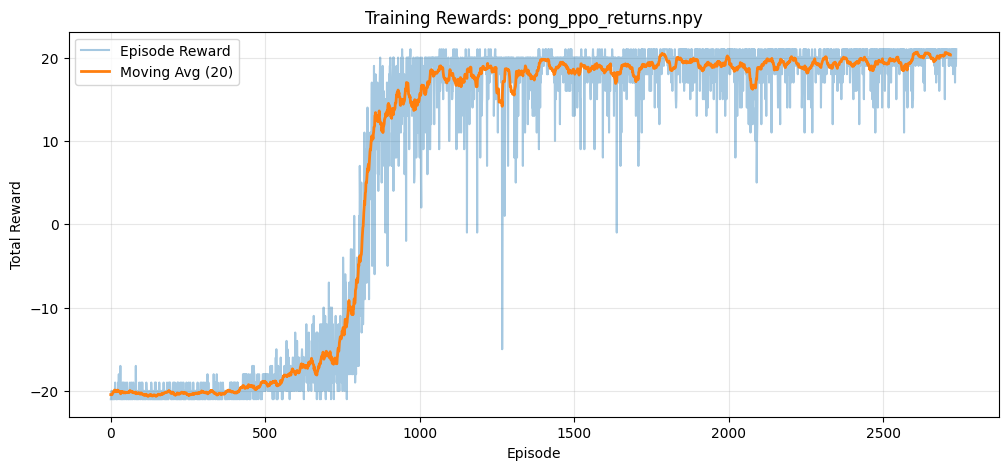

In [ ]:
# Plot total episode rewards (PPO) from saved returns file

import numpy as np
import matplotlib.pyplot as plt

def plot_returns(path="pong_ppo_returns.npy", window=20):
    returns = np.load(path)

    # Moving average for smoother curve
    if len(returns) >= window:
        mov_avg = np.convolve(returns, np.ones(window)/window, mode='valid')
    else:
        mov_avg = returns

    plt.figure(figsize=(12,5))
    plt.plot(returns, label="Episode Reward", alpha=0.4)
    plt.plot(mov_avg, label=f"Moving Avg ({window})", linewidth=2)
    plt.title(f"Training Rewards: {path}")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

# Example usage:
plot_returns("pong_ppo_returns.npy")
